<a href="https://colab.research.google.com/github/enisbe/stock-trading-app/blob/main/model/strategy_and_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Strategy

Portfolio Strategy using predicted prices of S&P 500 as basis. Only top 20 stocks with the highest expected return are selected in the portfolio and portfolio optimization is conducted on the selected 20 stocks. 

#Accessing Market Data  <a class="anchor" id="second-bullet"></a>

In [1]:
%%capture
!pip install matplotlib==3.2.2
!pip install plotly
!pip install pandas numpy yfinance PyPortfolioOpt yahooquery

In [2]:
# Load the required modules and packages
import numpy as np
import pandas as pd
import pandas_datareader as web
import pandas_datareader
import datetime
import pandas_datareader.data as web
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import pypfopt
from pypfopt import plotting
import yfinance as yf
from yahooquery import Ticker

In [ ]:
%matplotlib inline
plt.close('all')


In [ ]:
# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df_sp500 = first_table.convert_dtypes()
df_sp500.convert_dtypes()
df_sp500.to_csv('sp500' + '.csv', index=False)
df_sp500.info()
df_sp500.head(1)

In [ ]:
symbols = sp500.Symbol.tolist()

tickers = Ticker(symbols, asynchronous=True)

data = tickers.history(period ="1d", interval="5m")

In [ ]:
for key in data:
    if isinstance(data[key], pd.DataFrame):
        data[key]['symbol'] = key

# Concat all dataframes
df = pd.concat([data[k] for k in data if isinstance(data[k], pd.DataFrame)])

In [ ]:
SPY=Ticker('SPY',asynchronous=True)
data1=SPY.history(period ="1d", interval="5m")

In [ ]:
for key in data1:
    if isinstance(data1[key], pd.DataFrame):
        data1[key]['symbol'] = key

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df_cleaned=df[['index','close','symbol']]

In [ ]:
df_cleaned['date']=df_cleaned['index']

In [ ]:
pivoted = df_cleaned.pivot(index='date', columns="symbol", values="close")

In [ ]:
pivoted2=pivoted.copy()

In [ ]:
data1.reset_index(inplace=True)

In [ ]:
df1_cleaned=data1[['date','close','symbol']]

In [ ]:
pivoted1 = df1_cleaned.pivot(index='date', columns="symbol", values="close")

# Portfolio Strategy

### Portfolio Optimization based on max sharpe ratio

In [ ]:
import pandas as pd
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns  
import cvxpy as cp
# Read in price data
#df=pd.read_csv('all_price_close.csv',index_col="Date")
# Calculate expected returns and covariance
all=pivoted.copy()
mu = expected_returns.mean_historical_return(pivoted, frequency=len(pivoted.index))
mu1 = mu.sort_values(ascending=False).head(20)
df_S=pivoted[[x for x in mu1.index]]
S = risk_models.sample_cov(df_S,frequency=len(pivoted.index))

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu1, S)
#ef = EfficientFrontier(mu,S1)
#ef.add_objective(objective_functions.L2_reg, gamma=1)
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3]+w[4]+w[5]+w[6]+w[7]
                  +w[8]+w[9]+w[10]+w[11]+w[12]+w[13]
                  +w[14]+w[15]+w[16]+w[17]+w[18]+w[19]
                  == int(1))
ef.add_constraint((lambda w: cp.sum(w) == 1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights(rounding=3)
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

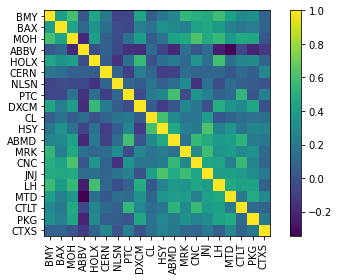

In [ ]:
plotting.plot_covariance(S, plot_correlation=True)

In [ ]:
pd.Series(cleaned_weights).plot.pie(figsize=(10, 10))

## Discrete Allocation

Discrete Allocation of Portfolio Strategies.Convert optimized weight into actual allocation of stock shares available for purchase by entering the latest price and investment size.

In [ ]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(df_S)
weights = cleaned_weights 
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Normalize Weights to ensure sum of weights == 1

In [ ]:
strategy1=dict(cleaned_weights)
strategy2=dict(cleaned_weights2)

In [ ]:
weight1=pd.DataFrame(strategy1.items(), columns=['ticker','weight'])
weight2=pd.DataFrame(strategy2.items(), columns=['ticker','weight'])

In [ ]:
s1=sum(weight1.weight)
s2=sum(weight2.weight)

In [ ]:
weight1.weight=weight1.weight/s1
weight2.weight=weight2.weight/s2

In [ ]:
weight1.set_index('ticker')
weight2.set_index('ticker')

In [ ]:
strategy_nor1=dict(zip(weight1.ticker, weight1.weight))

In [ ]:
strategy_nor2=dict(zip(weight2.ticker, weight2.weight))

# Backtesting using Self-Designed Function

In [ ]:
#Portfolio Asset Allocation. 
labels = weight1.ticker.to_list()
allocation_pct = weight1.weight.to_list()

fig = go.Figure(data=[go.Pie(labels=labels, values=allocation_pct)])
fig.update_layout(title="Portfolio Asset Allocation")
fig.show()

In [ ]:
# Calculate the cumulative return
for t in labels: 
  pivoted[t+'Cum Return'] = pivoted[t]/pivoted.iloc[0][t]

In [ ]:
# Calculate value of initial investment of 10K in the Portfolio

init_investment = 20000
for t, alloc in zip(labels,allocation_pct):
  pivoted[t+'Value'] = alloc*init_investment*pivoted[t+'Cum Return']


In [ ]:
# Combine All values
all_vals =[pivoted[t+'Value'] for t in labels]
portfolio_val = pd.concat(all_vals, axis=1)
portfolio_val.columns = labels
# Calculate Cumulative Return and Cumulative Return %
portfolio_val['Portfolio Total'] = round(portfolio_val.sum(axis=1))
portfolio_val['Cum Return'] = portfolio_val['Portfolio Total']/portfolio_val.iloc[0]['Portfolio Total']
portfolio_val['Cum Return %'] = (portfolio_val['Cum Return'] - 1) * 100

In [ ]:
SPY=data1.copy()
SPY['Cum Return']= SPY['close']/SPY.iloc[0]['close']
# Calculate value of initial investment of 10K in the SPY
SPY['SPY Total'] = init_investment*SPY['Cum Return']
SPY['SPY Total'] = round(SPY['SPY Total'])
SPY['Cum Return %'] = (SPY['Cum Return'] - 1) * 100

In [ ]:
# Visualize Portfolio Value and Compare it to SPY benchmark
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_val.index, y=portfolio_val['Portfolio Total'], name='Portfolio Total'))
fig.add_trace(go.Scatter(x=SPY.date, y=SPY['SPY Total'],name='SPY Total'))
fig.update_layout(title="Portfolio Value")

In [ ]:
# Visualize Return %
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio_val.index, y= portfolio_val['Cum Return %'], name='Portfolio Cumulative Return %'))
fig.add_trace(go.Scatter(x=SPY.date, y=SPY['Cum Return %'],name='SPY Cumulative Return %'))
fig.update_layout(title="Cumulative Return % (Portfolio vs SPY)")

In [ ]:
d1=portfolio_val['Portfolio Total'].reset_index()
d2=SPY[['date','SPY Total']]
d1['date'] = pd.to_datetime(d1['date'], errors='coerce')
d2['date'] = pd.to_datetime(d2['date'], errors='coerce')

Correlation between Current Portfolio and SPY

In [ ]:
print("Portfolio Correlation with SPY")
round(d1['Portfolio Total'].corr(d2['SPY Total']),2)